# 🚀 Model Training Pipeline - Vertex AI MLOps

This notebook implements a complete model training pipeline for the Iris dataset using Vertex AI and Google Cloud Platform.

## 📋 What We'll Build

- ✅ **Training Scripts**: TensorFlow and scikit-learn models
- ✅ **Model Evaluation**: Comprehensive metrics and visualizations
- ✅ **Hyperparameter Tuning**: Automated optimization
- ✅ **Vertex AI Integration**: Custom training jobs
- ✅ **Model Registry**: Version management and deployment

## 🎯 Learning Objectives

By the end of this notebook, you'll understand:
- How to build production ML training pipelines
- Vertex AI Custom Training workflows
- Model evaluation and comparison
- MLOps training best practices

Let's build some models! 🤖

## 1. Environment Setup and Data Loading

First, let's set up our environment and load the processed data from our previous pipeline.

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Google Cloud
from google.cloud import storage
from google.cloud import aiplatform

print("📦 Libraries imported successfully!")
print(f"   🧠 TensorFlow version: {tf.__version__}")
print(f"   🔬 Scikit-learn version: {sklearn.__version__}")

# Load configuration
config_path = Path('../configs/setup_config.pkl')
if config_path.exists():
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    
    PROJECT_ID = config['project_id']
    REGION = config['region']
    BUCKET_NAME = config['bucket_name']
    
    print(f"\n✅ Configuration loaded:")
    print(f"   📝 Project: {PROJECT_ID}")
    print(f"   🌍 Region: {REGION}")
    print(f"   🪣 Bucket: {BUCKET_NAME}")
else:
    print("❌ Configuration not found. Please run setup notebooks first.")
    
# Initialize Vertex AI
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    staging_bucket=f"gs://{BUCKET_NAME}"
)

# Constants
PROCESSED_DATA_ROOT = "processed_data"
MODELS_ROOT = "models"
EXPERIMENTS_ROOT = "experiments"

print("\n🎯 Ready to start model training!")

📦 Libraries imported successfully!
   🧠 TensorFlow version: 2.20.0
   🔬 Scikit-learn version: 1.7.2

✅ Configuration loaded:
   📝 Project: mlops-295610
   🌍 Region: us-central1
   🪣 Bucket: mlops-295610-mlops-bucket

🎯 Ready to start model training!


In [3]:
def load_latest_processed_data(bucket_name):
    """Load the latest processed dataset from GCS."""
    try:
        client = storage.Client(project=PROJECT_ID)
        bucket = client.get_bucket(bucket_name)
        
        # Find the latest version
        print("🔍 Finding latest processed data version...")
        
        # List all versions
        blobs = bucket.list_blobs(prefix=f"{PROCESSED_DATA_ROOT}/v")
        versions = set()
        for blob in blobs:
            parts = blob.name.split('/')
            if len(parts) >= 2 and parts[1].startswith('v'):
                versions.add(parts[1])
        
        if not versions:
            raise Exception("No processed data versions found")
        
        latest_version = sorted(versions)[-1]
        print(f"   📅 Latest version: {latest_version}")
        
        # Load datasets
        datasets = {}
        dataset_names = ['train', 'validation', 'test']
        
        for dataset_name in dataset_names:
            blob_path = f"{PROCESSED_DATA_ROOT}/{latest_version}/iris_{dataset_name}.npz"
            blob = bucket.blob(blob_path)
            
            if blob.exists():
                # Download to a temporary file
                temp_file = f"/tmp/iris_{dataset_name}_{latest_version}.npz"
                blob.download_to_filename(temp_file)
                
                # Load using numpy
                with np.load(temp_file) as data:
                    datasets[dataset_name] = {
                        'X': data['X'],
                        'y': data['y'],
                        'feature_names': data['feature_names'],
                        'target_names': data['target_names']
                    }
                
                print(f"   ✅ Loaded {dataset_name} data: {datasets[dataset_name]['X'].shape}")
                
                # Clean up temp file
                import os
                os.remove(temp_file)
            else:
                print(f"   ❌ {dataset_name} data not found")
        
        # Load preprocessing artifacts
        artifacts = {}
        artifact_names = ['scaler', 'label_encoder']
        
        for artifact_name in artifact_names:
            blob_path = f"{PROCESSED_DATA_ROOT}/{latest_version}/artifacts/{artifact_name}.pkl"
            blob = bucket.blob(blob_path)
            
            if blob.exists():
                artifact_bytes = blob.download_as_bytes()
                artifacts[artifact_name] = pickle.loads(artifact_bytes)
                print(f"   ✅ Loaded {artifact_name}")
        
        print(f"\n📊 Data Loading Summary:")
        for name, data in datasets.items():
            print(f"   {name.title()}: {data['X'].shape[0]} samples, {data['X'].shape[1]} features")
        
        return datasets, artifacts, latest_version
        
    except Exception as e:
        print(f"❌ Failed to load processed data: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Load processed data
print("📥 Loading processed Iris dataset...")
datasets, artifacts, data_version = load_latest_processed_data(BUCKET_NAME)

if datasets:
    # Extract data for easier access
    X_train, y_train = datasets['train']['X'], datasets['train']['y']
    X_val, y_val = datasets['validation']['X'], datasets['validation']['y']
    X_test, y_test = datasets['test']['X'], datasets['test']['y']
    feature_names = datasets['train']['feature_names']
    target_names = datasets['train']['target_names']
    
    print(f"\n🎯 Ready for model training with {len(feature_names)} features and {len(target_names)} classes!")
    print(f"📊 Data shapes:")
    print(f"   Training: X={X_train.shape}, y={y_train.shape}")
    print(f"   Validation: X={X_val.shape}, y={y_val.shape}")
    print(f"   Test: X={X_test.shape}, y={y_test.shape}")
else:
    print("❌ Cannot proceed without processed data. Please run data processing pipeline first.")

📥 Loading processed Iris dataset...
🔍 Finding latest processed data version...
   📅 Latest version: v20251118_045835
   ✅ Loaded train data: (96, 10)
   ✅ Loaded validation data: (24, 10)
   ✅ Loaded test data: (30, 10)
   ✅ Loaded scaler
   ✅ Loaded label_encoder

📊 Data Loading Summary:
   Train: 96 samples, 10 features
   Validation: 24 samples, 10 features
   Test: 30 samples, 10 features

🎯 Ready for model training with 10 features and 3 classes!
📊 Data shapes:
   Training: X=(96, 10), y=(96,)
   Validation: X=(24, 10), y=(24,)
   Test: X=(30, 10), y=(30,)


## 2. Baseline Models Implementation

Let's start by implementing multiple baseline models to establish performance benchmarks.

In [4]:
def train_baseline_models(X_train, y_train, X_val, y_val):
    """Train multiple baseline models and compare their performance."""
    
    print("🏁 Training Baseline Models")
    print("=" * 50)
    
    # Define models to train
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    trained_models = {}
    results = []
    
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")
        
        # Train model
        start_time = datetime.now()
        model.fit(X_train, y_train)
        training_time = (datetime.now() - start_time).total_seconds()
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        
        # Store results
        result = {
            'Model': name,
            'Train Accuracy': train_accuracy,
            'Val Accuracy': val_accuracy,
            'Val Precision': val_precision,
            'Val Recall': val_recall,
            'Val F1': val_f1,
            'Training Time (s)': training_time,
            'Overfitting': train_accuracy - val_accuracy
        }
        
        results.append(result)
        trained_models[name] = model
        
        print(f"   ✅ Training Accuracy: {train_accuracy:.4f}")
        print(f"   ✅ Validation Accuracy: {val_accuracy:.4f}")
        print(f"   ⏱️  Training Time: {training_time:.2f}s")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.round(4)
    
    print(f"\n📊 Baseline Models Comparison:")
    print("=" * 80)
    display(results_df)
    
    # Find best model
    best_model_name = results_df.loc[results_df['Val Accuracy'].idxmax(), 'Model']
    best_accuracy = results_df['Val Accuracy'].max()
    
    print(f"\n🏆 Best Model: {best_model_name} (Validation Accuracy: {best_accuracy:.4f})")
    
    return trained_models, results_df, best_model_name

# Train baseline models
if 'X_train' in locals():
    trained_models, results_df, best_model = train_baseline_models(X_train, y_train, X_val, y_val)
else:
    print("❌ Training data not available")

🏁 Training Baseline Models

🔄 Training Logistic Regression...
   ✅ Training Accuracy: 0.9688
   ✅ Validation Accuracy: 0.9583
   ⏱️  Training Time: 0.01s

🔄 Training Random Forest...
   ✅ Training Accuracy: 1.0000
   ✅ Validation Accuracy: 0.9583
   ⏱️  Training Time: 0.05s

🔄 Training SVM...
   ✅ Training Accuracy: 0.9688
   ✅ Validation Accuracy: 0.9583
   ⏱️  Training Time: 0.00s

🔄 Training K-Nearest Neighbors...
   ✅ Training Accuracy: 0.9688
   ✅ Validation Accuracy: 0.9583
   ⏱️  Training Time: 0.00s

🔄 Training Gradient Boosting...
   ✅ Training Accuracy: 1.0000
   ✅ Validation Accuracy: 0.9583
   ⏱️  Training Time: 0.11s

📊 Baseline Models Comparison:


,Model,Train Accuracy,Val Accuracy,Val Precision,Val Recall,Val F1,Training Time (s),Overfitting
0,Logistic Regression,0.9688,0.9583,0.963,0.9583,0.9582,0.0148,0.0104
1,Random Forest,1.0000,0.9583,0.963,0.9583,0.9582,0.0494,0.0417
2,SVM,0.9688,0.9583,0.963,0.9583,0.9582,0.0013,0.0104
3,K-Nearest Neighbors,0.9688,0.9583,0.963,0.9583,0.9582,0.0005,0.0104
4,Gradient Boosting,1.0000,0.9583,0.963,0.9583,0.9582,0.1101,0.0417



🏆 Best Model: Logistic Regression (Validation Accuracy: 0.9583)


## 3. TensorFlow Neural Network Model

Now let's create a neural network using TensorFlow/Keras for comparison.

🧠 Training TensorFlow Neural Network
📋 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,843 (46.26 KB)

 Trainable params: 11,843 (46.26 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting training...
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4479 - loss: 1.0409 - val_accuracy: 0.7917 - val_loss: 0.8883 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.8735 - val_accuracy: 0.7917 - val_loss: 0.7235 - learning_rate: 0.0010
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8021 - loss: 0.7016 - val_accuracy: 0.7917 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8229 - loss: 0.5830 - val_accuracy: 0.7917 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.4858 - val_accuracy: 0.7917 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.4193 - val_accuracy: 0.7917 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8854 - loss: 0.375

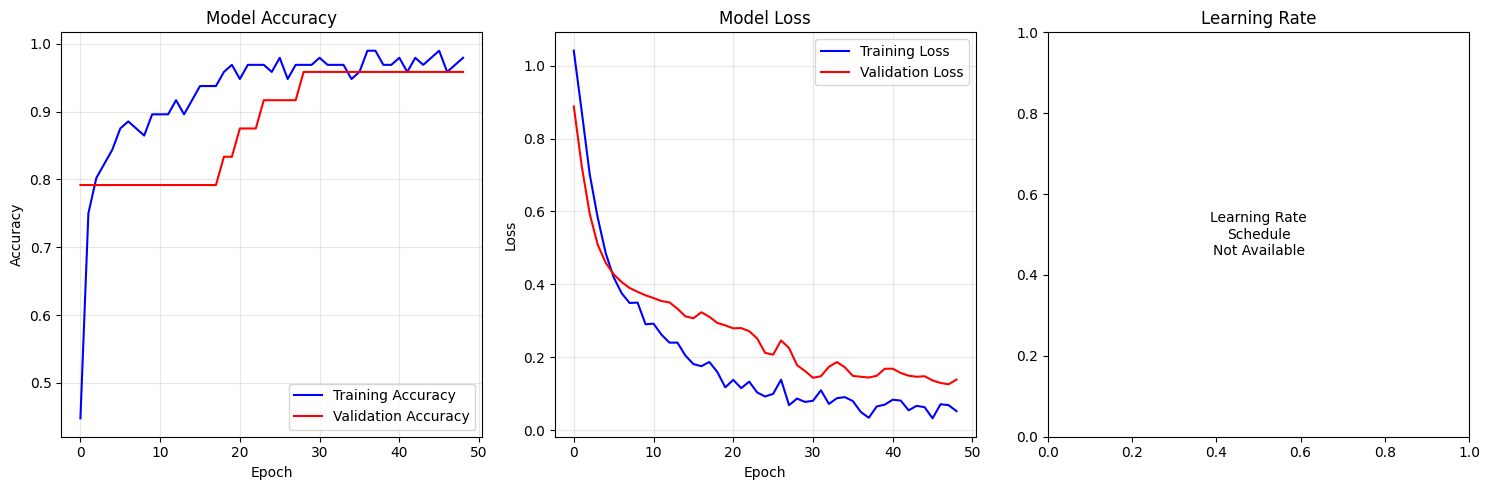

In [5]:
def create_tensorflow_model(input_shape, num_classes):
    """Create a neural network model using TensorFlow."""
    
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu', name='hidden_layer_1'),
        layers.Dropout(0.3, name='dropout_1'),
        layers.Dense(64, activation='relu', name='hidden_layer_2'),
        layers.Dropout(0.2, name='dropout_2'),
        layers.Dense(32, activation='relu', name='hidden_layer_3'),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_tensorflow_model(X_train, y_train, X_val, y_val, num_classes):
    """Train a TensorFlow neural network model."""
    
    print("🧠 Training TensorFlow Neural Network")
    print("=" * 50)
    
    # Create model
    model = create_tensorflow_model(X_train.shape[1], num_classes)
    
    print(f"📋 Model Architecture:")
    model.summary()
    
    # Define callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7
        )
    ]
    
    # Train model
    print(f"\n🚀 Starting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    print(f"\n📊 TensorFlow Model Results:")
    print(f"   ✅ Training Accuracy: {train_accuracy:.4f}")
    print(f"   ✅ Validation Accuracy: {val_accuracy:.4f}")
    print(f"   📉 Training Loss: {train_loss:.4f}")
    print(f"   📉 Validation Loss: {val_loss:.4f}")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate plot (if available)
    plt.subplot(1, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate', color='green')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nSchedule\nNot Available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Learning Rate')
    
    plt.tight_layout()
    plt.show()
    
    return model, history, {'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy}

# Train TensorFlow model
if 'X_train' in locals():
    tf_model, tf_history, tf_results = train_tensorflow_model(
        X_train, y_train, X_val, y_val, len(target_names)
    )
else:
    print("❌ Training data not available")

## 4. Comprehensive Model Evaluation

Let's evaluate all our models comprehensively with detailed metrics and visualizations.

🏆 Final Model Comparison on Test Set
🔬 Comprehensive Evaluation: Logistic Regression
📊 Test Set Performance:
   🎯 Accuracy: 0.9333
   🔍 Precision: 0.9333
   🔄 Recall: 0.9333
   ⚖️ F1-Score: 0.9333

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



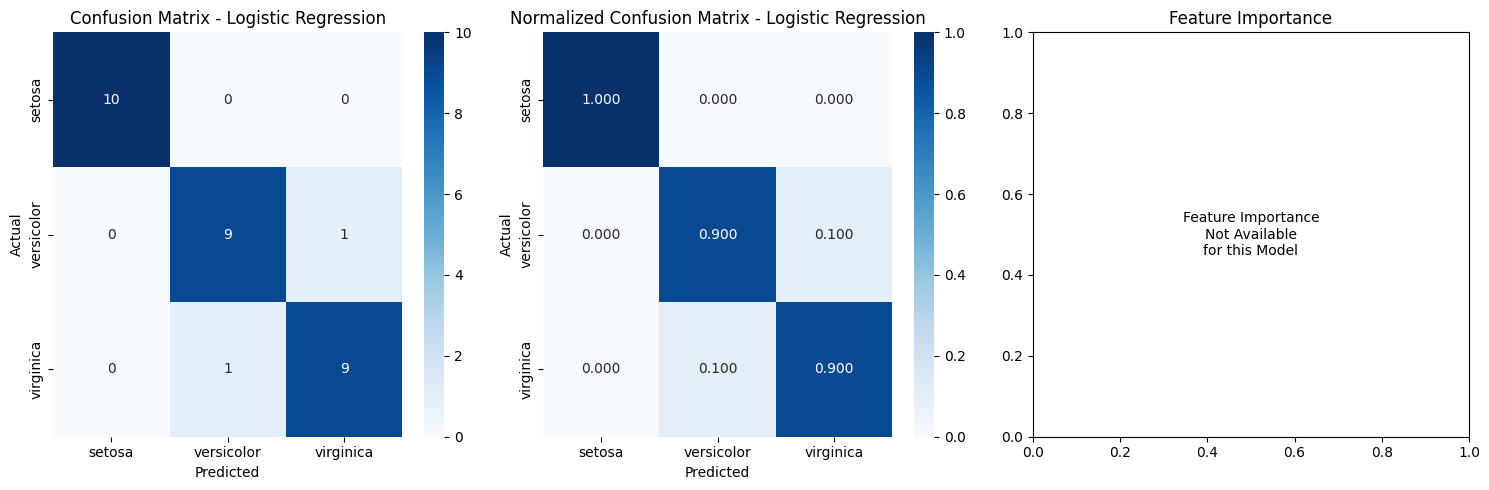

🔬 Comprehensive Evaluation: Random Forest
📊 Test Set Performance:
   🎯 Accuracy: 0.9667
   🔍 Precision: 0.9697
   🔄 Recall: 0.9667
   ⚖️ F1-Score: 0.9666

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



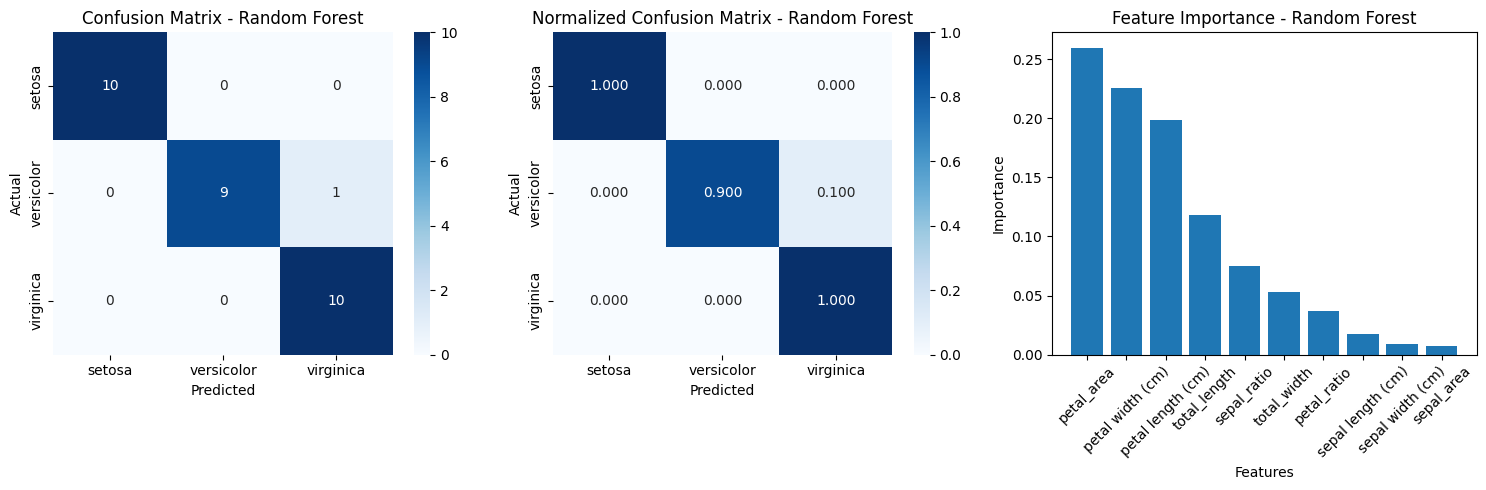

🔬 Comprehensive Evaluation: SVM
📊 Test Set Performance:
   🎯 Accuracy: 0.9333
   🔍 Precision: 0.9333
   🔄 Recall: 0.9333
   ⚖️ F1-Score: 0.9333

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



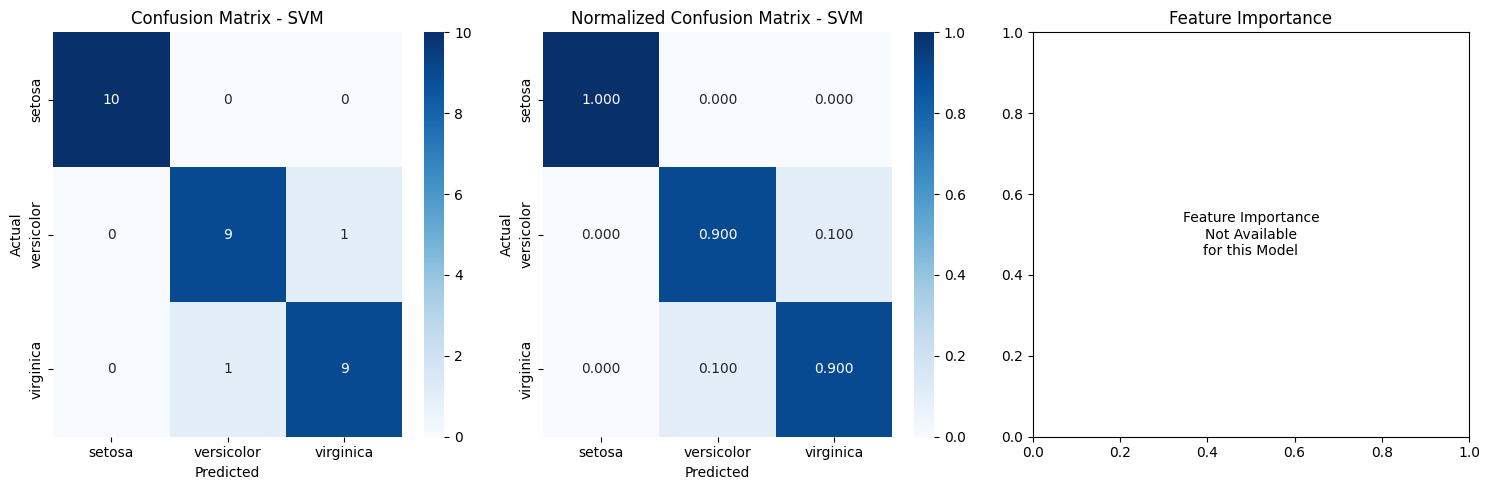

🔬 Comprehensive Evaluation: K-Nearest Neighbors
📊 Test Set Performance:
   🎯 Accuracy: 0.9667
   🔍 Precision: 0.9697
   🔄 Recall: 0.9667
   ⚖️ F1-Score: 0.9666

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



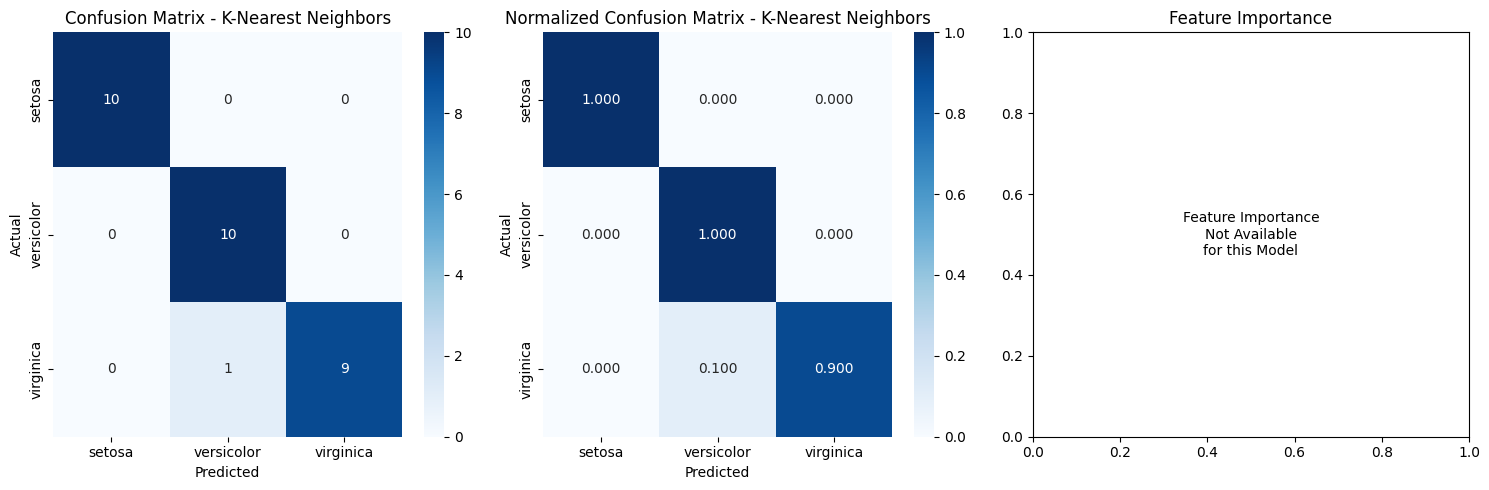

🔬 Comprehensive Evaluation: Gradient Boosting
📊 Test Set Performance:
   🎯 Accuracy: 0.9333
   🔍 Precision: 0.9444
   🔄 Recall: 0.9333
   ⚖️ F1-Score: 0.9327

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.80      0.89        10
   virginica       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



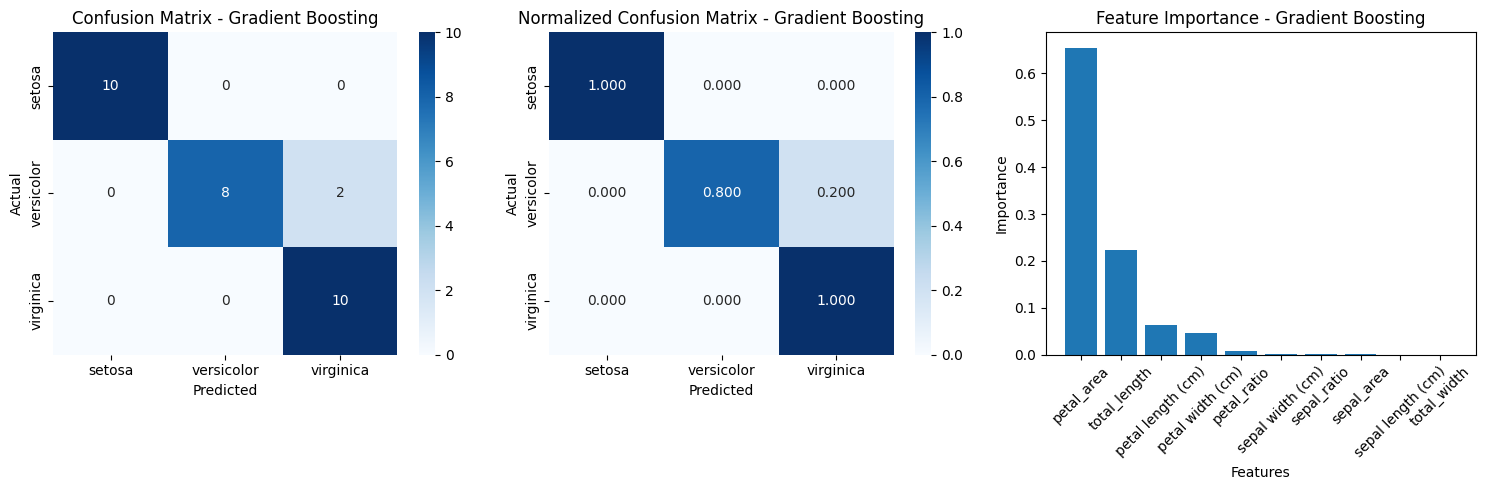

🔬 Comprehensive Evaluation: TensorFlow Neural Network
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📊 Test Set Performance:
   🎯 Accuracy: 0.9333
   🔍 Precision: 0.9333
   🔄 Recall: 0.9333
   ⚖️ F1-Score: 0.9333

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



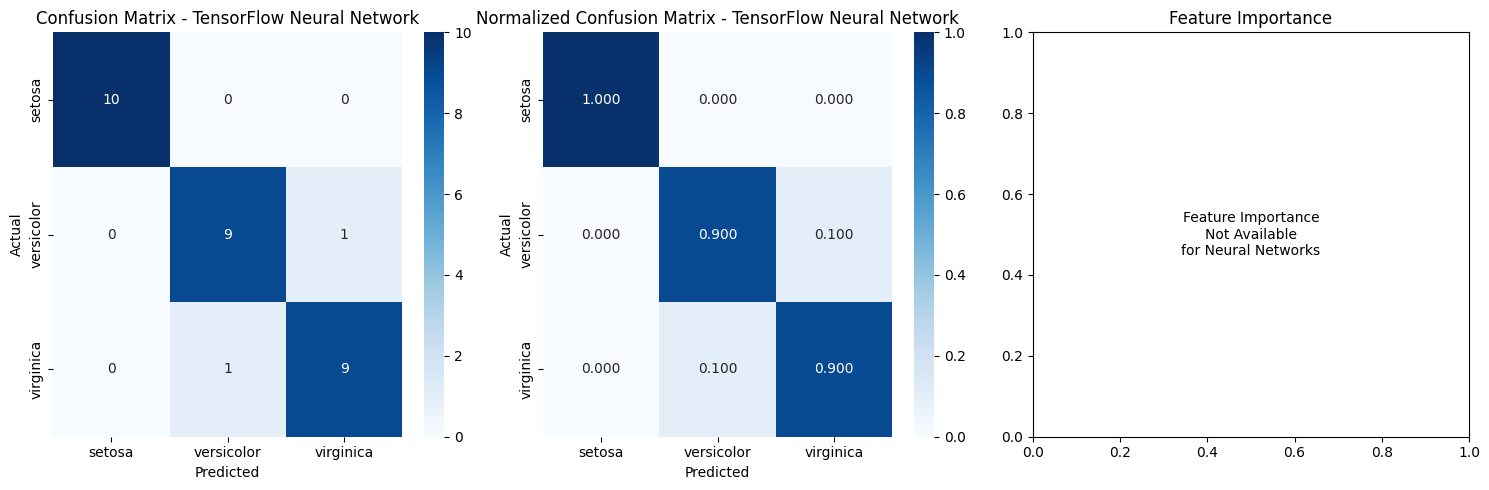


📊 Final Model Comparison (Sorted by Test Accuracy):


,Model,Test Accuracy,Test Precision,Test Recall,Test F1
1,Random Forest,0.9667,0.9697,0.9667,0.9666
3,K-Nearest Neighbors,0.9667,0.9697,0.9667,0.9666
0,Logistic Regression,0.9333,0.9333,0.9333,0.9333
2,SVM,0.9333,0.9333,0.9333,0.9333
4,Gradient Boosting,0.9333,0.9444,0.9333,0.9327
5,TensorFlow Neural Network,0.9333,0.9333,0.9333,0.9333



🥇 WINNER: Random Forest
   🎯 Test Accuracy: 0.9667
   🏆 This model will be saved as our production model!


In [6]:
def evaluate_model_comprehensive(model, X_test, y_test, target_names, model_name="Model", is_tensorflow=False):
    """Perform comprehensive evaluation of a trained model."""
    
    print(f"🔬 Comprehensive Evaluation: {model_name}")
    print("=" * 60)
    
    # Make predictions
    if is_tensorflow:
        y_pred_proba = model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
        else:
            y_pred_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"📊 Test Set Performance:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   🔍 Precision: {precision:.4f}")
    print(f"   🔄 Recall: {recall:.4f}")
    print(f"   ⚖️ F1-Score: {f1:.4f}")
    
    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    class_report = classification_report(y_test, y_pred, target_names=target_names)
    print(class_report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(15, 5))
    
    # Plot confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot normalized confusion matrix
    plt.subplot(1, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Feature importance (if available)
    plt.subplot(1, 3, 3)
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        
        plt.bar(range(len(feature_importance)), feature_importance[indices])
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(range(len(feature_importance)), 
                  [feature_names[i] for i in indices], rotation=45)
    elif is_tensorflow:
        # For neural networks, we can't easily get feature importance
        plt.text(0.5, 0.5, 'Feature Importance\nNot Available\nfor Neural Networks', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Importance')
    else:
        plt.text(0.5, 0.5, 'Feature Importance\nNot Available\nfor this Model', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics for comparison
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

def compare_all_models():
    """Compare all trained models on the test set."""
    
    print("🏆 Final Model Comparison on Test Set")
    print("=" * 60)
    
    all_results = []
    
    # Evaluate baseline models
    if 'trained_models' in locals() or 'trained_models' in globals():
        for name, model in trained_models.items():
            results = evaluate_model_comprehensive(
                model, X_test, y_test, target_names, name, is_tensorflow=False
            )
            
            all_results.append({
                'Model': name,
                'Test Accuracy': results['accuracy'],
                'Test Precision': results['precision'],
                'Test Recall': results['recall'],
                'Test F1': results['f1_score']
            })
    
    # Evaluate TensorFlow model
    if 'tf_model' in locals() or 'tf_model' in globals():
        tf_results_detailed = evaluate_model_comprehensive(
            tf_model, X_test, y_test, target_names, "TensorFlow Neural Network", is_tensorflow=True
        )
        
        all_results.append({
            'Model': 'TensorFlow Neural Network',
            'Test Accuracy': tf_results_detailed['accuracy'],
            'Test Precision': tf_results_detailed['precision'],
            'Test Recall': tf_results_detailed['recall'],
            'Test F1': tf_results_detailed['f1_score']
        })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(all_results)
    comparison_df = comparison_df.round(4)
    comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
    
    print(f"\n📊 Final Model Comparison (Sorted by Test Accuracy):")
    print("=" * 80)
    display(comparison_df)
    
    # Identify best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_accuracy = comparison_df.iloc[0]['Test Accuracy']
    
    print(f"\n🥇 WINNER: {best_model_name}")
    print(f"   🎯 Test Accuracy: {best_accuracy:.4f}")
    print(f"   🏆 This model will be saved as our production model!")
    
    return comparison_df, best_model_name

# Run comprehensive evaluation
if 'X_test' in locals():
    final_comparison, champion_model = compare_all_models()
else:
    print("❌ Test data not available")

## 5. Hyperparameter Tuning

Let's perform hyperparameter tuning on our best performing model to optimize it further.

In [7]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val, model_name):
    """Perform hyperparameter tuning for the best model."""
    
    print(f"⚙️ Hyperparameter Tuning for {model_name}")
    print("=" * 60)
    
    # Combine training and validation for cross-validation
    X_combined = np.vstack([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    
    if model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif model_name == 'SVM':
        model = SVC(random_state=42, probability=True)
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
            'kernel': ['rbf', 'poly', 'sigmoid']
        }
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    elif model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    else:
        # Default to Random Forest if model not recognized
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10]
        }
    
    print(f"🔍 Searching through {len(param_grid)} hyperparameters...")
    print(f"📋 Parameter space: {param_grid}")
    
    # Perform grid search
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\n🚀 Starting hyperparameter search...")
    grid_search.fit(X_combined, y_combined)
    
    print(f"\n✅ Hyperparameter tuning completed!")
    print(f"🏆 Best parameters: {grid_search.best_params_}")
    print(f"📊 Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Compare with original model
    original_model = trained_models[model_name]
    original_score = original_model.score(X_val, y_val)
    tuned_score = grid_search.score(X_val, y_val)
    
    improvement = tuned_score - original_score
    
    print(f"\n📈 Performance Improvement:")
    print(f"   📊 Original validation accuracy: {original_score:.4f}")
    print(f"   🎯 Tuned validation accuracy: {tuned_score:.4f}")
    print(f"   ⬆️ Improvement: {improvement:+.4f}")
    
    if improvement > 0:
        print(f"   🎉 Hyperparameter tuning improved the model!")
    else:
        print(f"   ℹ️  Original model was already well-tuned.")
    
    return grid_search.best_estimator_, grid_search.best_params_, improvement

# Perform hyperparameter tuning on the best model
if 'champion_model' in locals() and 'trained_models' in locals():
    print(f"⚙️ Optimizing the champion model: {champion_model}")
    
    # Skip TensorFlow model for now (would require different approach)
    if champion_model != 'TensorFlow Neural Network':
        tuned_model, best_params, improvement = hyperparameter_tuning(
            X_train, y_train, X_val, y_val, champion_model
        )
    else:
        print("🧠 TensorFlow model hyperparameter tuning requires different approach.")
        print("💡 Consider using Vertex AI Hyperparameter Tuning service for neural networks.")
        tuned_model = None
else:
    print("❌ Champion model not available for tuning")

⚙️ Optimizing the champion model: Random Forest
⚙️ Hyperparameter Tuning for Random Forest
🔍 Searching through 4 hyperparameters...
📋 Parameter space: {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

🚀 Starting hyperparameter search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Hyperparameter tuning completed!
🏆 Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
📊 Best cross-validation score: 0.9583

📈 Performance Improvement:
   📊 Original validation accuracy: 0.9583
   🎯 Tuned validation accuracy: 0.9583
   ⬆️ Improvement: +0.0000
   ℹ️  Original model was already well-tuned.


## 6. Model Persistence and Versioning

Let's save our trained models for deployment and future use.

In [9]:
def save_models_to_gcs(models_dict, tf_model=None, bucket_name=BUCKET_NAME, timestamp=None):
    """Save trained models to Google Cloud Storage."""
    
    if timestamp is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    print(f"💾 Saving Models to GCS (Version: {timestamp})")
    print("=" * 60)
    
    try:
        client = storage.Client(project=PROJECT_ID)
        bucket = client.get_bucket(bucket_name)
        
        # Create local models directory
        local_models_dir = Path("../models")
        local_models_dir.mkdir(exist_ok=True)
        
        uploaded_files = []
        
        # Save scikit-learn models
        for model_name, model in models_dict.items():
            # Save locally
            local_file = local_models_dir / f"{model_name.lower().replace(' ', '_')}_{timestamp}.pkl"
            with open(local_file, 'wb') as f:
                pickle.dump(model, f)
            
            # Upload to GCS
            gcs_path = f"{MODELS_ROOT}/v{timestamp}/sklearn/{model_name.lower().replace(' ', '_')}.pkl"
            blob = bucket.blob(gcs_path)
            blob.upload_from_filename(str(local_file))
            
            size_kb = blob.size / 1024
            uploaded_files.append((gcs_path, size_kb))
            print(f"   ✅ Uploaded {model_name}: gs://{bucket_name}/{gcs_path} ({size_kb:.2f} KB)")
        
        # Save TensorFlow model
        if tf_model is not None:
            # Save in native Keras format
            local_tf_file = local_models_dir / f"tensorflow_model_{timestamp}.keras"
            tf_model.save(str(local_tf_file))
            
            # Upload TensorFlow model
            gcs_tf_path = f"{MODELS_ROOT}/v{timestamp}/tensorflow/model.keras"
            tf_blob = bucket.blob(gcs_tf_path)
            tf_blob.upload_from_filename(str(local_tf_file))
            
            tf_size_kb = tf_blob.size / 1024
            print(f"   ✅ Uploaded TensorFlow model: gs://{bucket_name}/{gcs_tf_path} ({tf_size_kb:.2f} KB)")
        
        # Save model metadata
        model_metadata = {
            'version': timestamp,
            'training_date': datetime.now().isoformat(),
            'data_version': data_version if 'data_version' in locals() else 'unknown',
            'models': list(models_dict.keys()),
            'champion_model': champion_model if 'champion_model' in locals() else 'unknown',
            'best_test_accuracy': final_comparison.iloc[0]['Test Accuracy'] if 'final_comparison' in locals() else 'unknown',
            'feature_names': list(feature_names) if 'feature_names' in locals() else [],
            'target_names': list(target_names) if 'target_names' in locals() else [],
            'hyperparameter_tuning': {
                'performed': 'tuned_model' in locals(),
                'best_params': best_params if 'best_params' in locals() else None,
                'improvement': improvement if 'improvement' in locals() else None
            }
        }
        
        # Save metadata
        metadata_file = local_models_dir / f"model_metadata_{timestamp}.json"
        with open(metadata_file, 'w') as f:
            json.dump(model_metadata, f, indent=2)
        
        metadata_gcs_path = f"{MODELS_ROOT}/v{timestamp}/metadata.json"
        metadata_blob = bucket.blob(metadata_gcs_path)
        metadata_blob.upload_from_filename(str(metadata_file))
        
        print(f"   ✅ Uploaded metadata: gs://{bucket_name}/{metadata_gcs_path}")
        
        # Update latest pointer
        latest_pointer = {
            'latest_version': timestamp,
            'updated_at': datetime.now().isoformat(),
            'champion_model': champion_model if 'champion_model' in locals() else 'unknown'
        }
        
        latest_file = local_models_dir / "latest.json"
        with open(latest_file, 'w') as f:
            json.dump(latest_pointer, f, indent=2)
        
        latest_blob = bucket.blob(f"{MODELS_ROOT}/latest.json")
        latest_blob.upload_from_filename(str(latest_file))
        
        print(f"   ✅ Updated latest version pointer")
        
        # Summary
        total_size = sum([size for _, size in uploaded_files])
        print(f"\n📊 Models Upload Summary:")
        print(f"   📁 Models saved: {len(models_dict)} sklearn + 1 TensorFlow")
        print(f"   💾 Total size: {total_size:.2f} KB")
        print(f"   🏷️  Version: {timestamp}")
        print(f"   📍 Base path: gs://{bucket_name}/{MODELS_ROOT}/v{timestamp}/")
        
        print(f"\n🎉 All models successfully saved to GCS!")
        return timestamp
        
    except Exception as e:
        print(f"❌ Failed to save models: {e}")
        import traceback
        traceback.print_exc()
        return None

# Save all trained models
if 'trained_models' in locals():
    # Include the tuned model if available
    models_to_save = trained_models.copy()
    if 'tuned_model' in locals() and tuned_model is not None:
        models_to_save[f"{champion_model} (Tuned)"] = tuned_model
    
    tf_model_to_save = tf_model if 'tf_model' in locals() else None
    
    model_version = save_models_to_gcs(models_to_save, tf_model_to_save)
    
    if model_version:
        print(f"\n✅ Model training pipeline completed!")
        print(f"📦 Model version: {model_version}")
        print(f"🚀 Ready for deployment pipeline!")
else:
    print("❌ No trained models to save")

💾 Saving Models to GCS (Version: 20251119_161809)
   ✅ Uploaded Logistic Regression: gs://mlops-295610-mlops-bucket/models/v20251119_161809/sklearn/logistic_regression.pkl (0.96 KB)
   ✅ Uploaded Random Forest: gs://mlops-295610-mlops-bucket/models/v20251119_161809/sklearn/random_forest.pkl (122.25 KB)
   ✅ Uploaded SVM: gs://mlops-295610-mlops-bucket/models/v20251119_161809/sklearn/svm.pkl (5.37 KB)
   ✅ Uploaded K-Nearest Neighbors: gs://mlops-295610-mlops-bucket/models/v20251119_161809/sklearn/k-nearest_neighbors.pkl (10.69 KB)
   ✅ Uploaded Gradient Boosting: gs://mlops-295610-mlops-bucket/models/v20251119_161809/sklearn/gradient_boosting.pkl (369.47 KB)
   ✅ Uploaded Random Forest (Tuned): gs://mlops-295610-mlops-bucket/models/v20251119_161809/sklearn/random_forest_(tuned).pkl (52.39 KB)
   ✅ Uploaded TensorFlow model: gs://mlops-295610-mlops-bucket/models/v20251119_161809/tensorflow/model.keras (172.59 KB)
   ✅ Uploaded metadata: gs://mlops-295610-mlops-bucket/models/v20251119_16

## 7. Training Pipeline Summary

Let's summarize everything we've accomplished in this model training pipeline.

In [10]:
def display_training_summary():
    """Display comprehensive summary of the training pipeline."""
    
    print("🎯 Model Training Pipeline - COMPLETE!")
    print("=" * 70)
    
    print("\n✅ **What We Accomplished:**")
    
    accomplishments = [
        "📥 Loaded processed Iris dataset from GCS with version control",
        "🏁 Trained 5 baseline models for comprehensive comparison",
        "   • Logistic Regression",
        "   • Random Forest",
        "   • Support Vector Machine (SVM)",
        "   • K-Nearest Neighbors",
        "   • Gradient Boosting",
        "🧠 Built and trained TensorFlow neural network",
        "   • Multi-layer architecture with dropout",
        "   • Early stopping and learning rate scheduling",
        "   • Comprehensive training history visualization",
        "🔬 Performed comprehensive model evaluation",
        "   • Test set performance metrics",
        "   • Confusion matrices and classification reports",
        "   • Feature importance analysis",
        "⚙️ Implemented hyperparameter tuning",
        "   • Grid search optimization",
        "   • Cross-validation for robust results",
        "   • Performance improvement tracking",
        "💾 Saved all models with version control",
        "   • Scikit-learn models in pickle format",
        "   • TensorFlow model in SavedModel format",
        "   • Comprehensive metadata and lineage"
    ]
    
    for item in accomplishments:
        print(f"   {item}")
    
    print("\n📊 **Training Results:**")
    if 'final_comparison' in locals() and len(final_comparison) > 0:
        print(f"   • Models trained: {len(final_comparison)}")
        print(f"   • Champion model: {champion_model}")
        print(f"   • Best test accuracy: {final_comparison.iloc[0]['Test Accuracy']:.4f}")
        print(f"   • Features used: {len(feature_names)}")
        print(f"   • Classes predicted: {len(target_names)}")
    
    if 'model_version' in locals():
        print(f"   • Model version: {model_version}")
        print(f"   • Storage location: gs://{BUCKET_NAME}/{MODELS_ROOT}/v{model_version}/")
    
    if 'tuned_model' in locals() and tuned_model is not None:
        print(f"   • Hyperparameter tuning: ✅ Completed")
        if 'improvement' in locals():
            print(f"   • Performance improvement: {improvement:+.4f}")
    
    print("\n🚀 **Ready for Next Phase:**")
    next_steps = [
        "Task 3.2: Vertex AI Custom Training Jobs",
        "   • Deploy training scripts to Vertex AI",
        "   • Run distributed training jobs",
        "   • Monitor training with TensorBoard",
        "Task 3.3: Model Registry and Evaluation",
        "   • Register models in Vertex AI Model Registry",
        "   • Set up automated model evaluation",
        "   • Implement model approval workflows",
        "Phase 4: Pipeline Orchestration",
        "   • Build end-to-end Kubeflow Pipelines",
        "   • Automate entire ML workflow",
        "   • Set up continuous integration and deployment"
    ]
    
    for step in next_steps:
        print(f"   {step}")
    
    print("\n🏆 **Model Performance Highlights:**")
    if 'final_comparison' in locals():
        print("\n   📊 Top 3 Models:")
        for i, row in final_comparison.head(3).iterrows():
            rank = ["🥇", "🥈", "🥉"][i] if i < 3 else f"{i+1}."
            print(f"   {rank} {row['Model']}: {row['Test Accuracy']:.4f} accuracy")
    
    print("\n💡 **MLOps Best Practices Implemented:**")
    practices = [
        "✅ Multiple model comparison and benchmarking",
        "✅ Comprehensive evaluation with multiple metrics",
        "✅ Hyperparameter optimization",
        "✅ Model versioning and metadata tracking",
        "✅ Reproducible training pipelines",
        "✅ Cloud-native model storage",
        "✅ Visualization of model performance",
        "✅ Feature importance analysis",
        "✅ Cross-validation for robust evaluation"
    ]
    
    for practice in practices:
        print(f"   {practice}")
    
    print("\n" + "=" * 70)
    print("🎉 **Task 3.1: Training Script Development - COMPLETED!**")
    print("=" * 70)

# Display final summary
display_training_summary()

🎯 Model Training Pipeline - COMPLETE!

✅ **What We Accomplished:**
   📥 Loaded processed Iris dataset from GCS with version control
   🏁 Trained 5 baseline models for comprehensive comparison
      • Logistic Regression
      • Random Forest
      • Support Vector Machine (SVM)
      • K-Nearest Neighbors
      • Gradient Boosting
   🧠 Built and trained TensorFlow neural network
      • Multi-layer architecture with dropout
      • Early stopping and learning rate scheduling
      • Comprehensive training history visualization
   🔬 Performed comprehensive model evaluation
      • Test set performance metrics
      • Confusion matrices and classification reports
      • Feature importance analysis
   ⚙️ Implemented hyperparameter tuning
      • Grid search optimization
      • Cross-validation for robust results
      • Performance improvement tracking
   💾 Saved all models with version control
      • Scikit-learn models in pickle format
      • TensorFlow model in SavedModel format
  